# CPSC 340 Assignment 6

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

## Instructions
rubric={mechanics:5}


The above points are allocated for following the [homework submission instructions](https://github.ugrad.cs.ubc.ca/CPSC340-2017W-T2/home/blob/master/homework_instructions.md).

## Exercise 1: Finding similar items

For this question we'll be using the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the "Patio, Lawn, and Garden" section. Download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place the file in the `data` directory with the original filename. Once you do that, the code below should load the data:

In [37]:
filename = "ratings_Patio_Lawn_and_Garden.csv"

with open(os.path.join("..", "data", filename), "rb") as f:
    ratings = pd.read_csv(f,names=("user","item","rating","timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


We'd also like to construct the user-product matrix `X`. Let's see how big it would be:

In [38]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    d = len(set(ratings[item_key]))
    n = len(set(ratings[user_key]))
    print("Number of users:", n)
    print("Number of items:", d)
    print("Fraction nonzero:", len(ratings)/(n*d))
    print("Size of full X matrix: %.2f GB" % ((n*d)*8/1e9))

    return n,d

n,d = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full X matrix: 606.05 GB


600 GB! That is way too big. We don't want to create that matrix. On the other hand, we see that we only have about 1 million ratings, which would be around 8 MB ($10^6$ numbers $\times$ at 8 bytes per double precision floating point number). Much more manageable. 

In [39]:
def create_X(ratings,n,d,user_key="user",item_key="item"):
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(n))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(d))))

    user_inverse_mapper = dict(zip(list(range(n)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(d)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = sparse_matrix((ratings["rating"], (user_ind, item_ind)), shape=(n,d))
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n, d)

In [40]:
# sanity check
print(X.shape) # should be number of users by number of items
print(X.nnz)   # number of nonzero elements -- should equal number of ratings

(714791, 105984)
993490


In [41]:
X.data.nbytes

7947920

(Above: verifying our estimate of 8 MB to store sparse `X`)

### 1.1
rubric={reasoning:2}

Find the following items:

1. the item with the most reviews
2. the item with the most total stars
3. the item with the highest average stars

Then, find the names of these items by looking them up with the url https://www.amazon.com/dp/ITEM_ID, where `ITEM_ID` is the id of the item.

In [42]:
url_amazon = "https://www.amazon.com/dp/%s"

# example:
print(url_amazon % 'B00CFM0P7Y')

https://www.amazon.com/dp/B00CFM0P7Y


In [44]:
### YOUR CODE HERE ###
# 1.1
# the item with most reviews

from collections import Counter

user,item = X.nonzero()
N = len(user)
Nreview_item = Counter(item).most_common()
MaxReview = Nreview_item[0]

print("the item with the most reviews:Classic Accessories 73942 Veranda Grill Cover")
print(url_amazon % item_inverse_mapper[MaxReview[0]])

# the item with the most total stars
# the item with the highest average stars
sumstars = np.zeros(d)
mean = np.zeros(d)

for i in range(d):
    tt = X[:,i].nonzero()
    ttemp = X[ tt[0],i ]
    sumstars[i] = np.sum(ttemp)
    mean[i] = sumstars[i]/ len(tt[0])
  
# MaxTotal = Nreview_item [ np.argmax(temp) ][0]
MaxTotal = np.argmax(sumstars)
print("the item with the most total stars:Classic Accessories 73942 Veranda Grill Cover")
print(url_amazon % item_inverse_mapper[MaxTotal])


MaxMean = np.argmax(mean)
print("the item with the highest average stars:Primal Grill with Steven Raichlen, Volume One DVD")
print(url_amazon % item_inverse_mapper[MaxMean])

# save the sumstars matrix 
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.save(outfile, sumstars)
outfile.seek(0) # Only needed here to simulate closing & reopening file
np.load(outfile)

the item with the most reviews:Classic Accessories 73942 Veranda Grill Cover
https://www.amazon.com/dp/B000HCLLMM
the item with the most total stars:Classic Accessories 73942 Veranda Grill Cover
https://www.amazon.com/dp/B000HCLLMM
the item with the highest average stars:Primal Grill with Steven Raichlen, Volume One DVD
https://www.amazon.com/dp/0981850006


array([ 35.,  11.,  10., ...,  30.,  25.,  25.])

### 1.2
rubric={reasoning:2}

Make the following histograms 

1. The number of ratings per user
2. The number of ratings per item
3. The ratings themselves

For the first two, use
```
plt.yscale('log', nonposy='clip')
``` 
to put the histograms on a log-scale.

Figure saved as '..\figs\The number of ratings per user.png'
Figure saved as '..\figs\The number of ratings per item.png'
Figure saved as '..\figs\The number of of that rating.png'


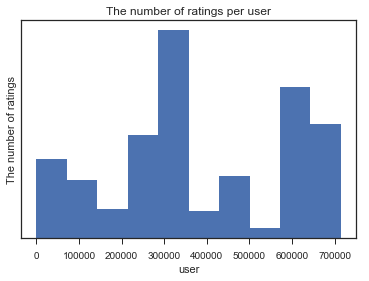

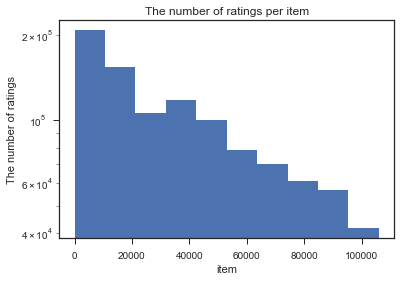

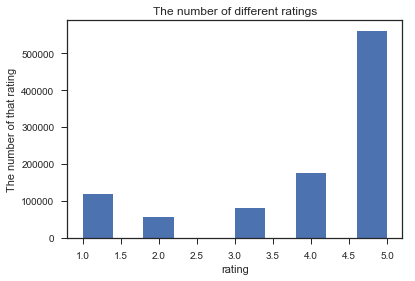

In [45]:
### YOUR CODE HERE ###
user,item = X.nonzero()
N = len(user)
Nreview_item = Counter(item).most_common()
Nreview_user = Counter(user).most_common()


FIGS_DIR = 'figs'
def savefig(fname, verbose=True):
    path = os.path.join('..', FIGS_DIR, fname)
    plt.savefig(path)
    if verbose:
        print("Figure saved as '{}'".format(path))


fig = plt.figure()
plt.hist( user )
plt.yscale('log', nonposy='clip')
plt.title("The number of ratings per user")
plt.xlabel("user")
plt.ylabel("The number of ratings")
savefig('The number of ratings per user.png' )

fig = plt.figure()
plt.hist( item )
plt.yscale('log', nonposy='clip')
plt.title("The number of ratings per item")
plt.xlabel("item")
plt.ylabel("The number of ratings")
savefig('The number of ratings per item.png' )

Rat = X[user,item]
Rat_array = np.squeeze(np.asarray(Rat)) # transform a matrix into array
Ratings = Rat_array.astype(int) # transform a float array into int array
fig = plt.figure()
plt.hist( Ratings )
plt.title("The number of different ratings")
plt.xlabel("rating")
plt.ylabel("The number of that rating")
savefig('The number of of that rating.png' )



### 1.3
rubric={reasoning:1}

Use scikit-learn's [NearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object (which uses Euclidean distance by default) to find the 5 items most similar to [Brass Grill Brush 18 Inch Heavy Duty and Extra Strong, Solid Oak Handle](https://www.amazon.com/dp/B00CFM0P7Y). 

The code block below grabs the column of `X` associated with the grill brush. The mappers take care of going back and forther between the IDs (like `B00CFM0P7Y`) and the indices of the sparse array (0,1,2,...).

Note: keep in mind that `NearestNeighbors` is for taking neighbors across rows, but here we're working across columns.

In [46]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X[:,grill_brush_ind]

print(url_amazon % grill_brush)

https://www.amazon.com/dp/B00CFM0P7Y


In [47]:
### YOUR CODE HERE ###
Xtranspose = np.transpose(X)


neigh = NearestNeighbors(n_neighbors=6).fit(Xtranspose)
distances, indices = neigh.kneighbors(np.transpose(grill_brush_vec))

print("ind the 5 items most similar to Brass Grill Brush are:")  
for i in range(6):
    print(url_amazon % item_inverse_mapper[indices[0][i]])
    
print("The first one is the grill brush itself. To find 5 items most similar to this grill brush, we need to set 'n_neighbour = 6'")
    

ind the 5 items most similar to Brass Grill Brush are:
https://www.amazon.com/dp/B00CFM0P7Y
https://www.amazon.com/dp/B00IJB5MCS
https://www.amazon.com/dp/B00IJB4MLA
https://www.amazon.com/dp/B00EXE4O42
https://www.amazon.com/dp/B00743MZCM
https://www.amazon.com/dp/B00HVXQY9A
The first one is the grill brush itself. To find 5 items most similar to this grill brush, we need to set 'n_neighbour = 6'


The items which are most similar to Brass Grill Brush are:
1. Mr Grill - 18" Luxury Oak Barbecue Spatula / Turner
2. GrillHogs Basting Mop with Replacement Head, 18 Inch Handle with Machine Washable Heads
3. Syndicate Sales 9 1/2" Catalina Bowl, Black
4. and 5. are not found by the website.

We can find some patterns. They are all related to barbecue。

### 1.4
rubric={reasoning:1}

Using cosine similarity instead of Euclidean distance in `NearestNeighbors`, find the 5 products most similar to `B00CFM0P7Y`.

Same as before, The first one is the grill brush itself. 

To find 5 items most similar to this grill brush, we need to set 'n_neighbour = 6'.
    

In [48]:
### YOUR CODE HERE ###
neigh = NearestNeighbors(n_neighbors=6,metric = 'cosine').fit(Xtranspose)
Cosdistances, Cosindices = neigh.kneighbors(np.transpose(grill_brush_vec))

print("ind the 5 items most similar to Brass Grill Brush are:")  
for i in range(6):
    print(url_amazon % item_inverse_mapper[Cosindices[0][i]])


ind the 5 items most similar to Brass Grill Brush are:
https://www.amazon.com/dp/B00CFM0P7Y
https://www.amazon.com/dp/B00IJB5MCS
https://www.amazon.com/dp/B00IJB8F3G
https://www.amazon.com/dp/B00IJB4MLA
https://www.amazon.com/dp/B00EF45AHU
https://www.amazon.com/dp/B00EF3YF0Y


The items which are most similar to Brass Grill Brush are:
1. Mr Grill - 18" Luxury Oak Barbecue Spatula / Turner
2. GrillHogs Luxury Barbecue Grill Tongs 16 Inch, Oak and Stainless Steel
3. GrillHogs Basting Mop with Replacement Head, 18 Inch Handle with Machine Washable Heads
4. GrillHogs Marinade Injector Stainless Steel with 3 Marinade Needles
5. Mr Grill Silicone Oven Gloves Heat Resistant to 425°F / 218°C - Slip Resistant - Unlined and Dishwasher Washable

We can find some patterns. They are all related to barbecue.
In addition, plus the Brass Grill Brush, there are 4 items for GrillHoga, and 2 items from Mr.Grill.

### 1.5
rubric={reasoning:2}

For each of the two metrics, compute the compute the total popularity (total stars) of each of the 5 items and report it. Do the results make sense given what we discussed in class about Euclidean distance vs. cosine similarity? 


In [49]:
### YOUR CODE HERE ###
EuclidStar = []
CosStar = []
for i in range(5):
    Eu = X[ :,indices[0][i+1] ].data
    EuclidStar.append(sum(Eu))
    Cos = X[ :,Cosindices[0][i+1] ].data
    CosStar.append(sum(Cos))
    
print("the total popularity (total stars) of each of the 5 items(except the Brass Grill Brush itself) are:")
print("Euclidean distance", EuclidStar)
print("Cosine similarity", CosStar)

the total popularity (total stars) of each of the 5 items(except the Brass Grill Brush itself) are:
Euclidean distance [266.0, 205.0, 5.0, 5.0, 5.0]
Cosine similarity [266.0, 438.0, 205.0, 311.0, 513.0]



From the results, the total stars of cosine similarity is much larger than Euclidean distance.

Cosine similarity measures the angle between vectors (thus not taking into regard their weight or magnitude),
while Euclidean distance measures the distance.

When the magnitude of the vectors does not matter, Cosine similarity makes more sense, like text data represented by word counts. If a word occurs more times in essay 'A' only because essay 'A' has a longer length, cosine similarity will correct this.



### 1.6
rubric={reasoning:3}

PCA gives us an approximation $X \approx ZW$ where the rows of $Z$ contain a length-$k$ latent feature vectors for each user and the columns of $W$ contain a length-$k$ latent feature vectors for each item.

Another strategy for finding similar items is to run PCA and then search for nearest neighbours with Euclidean distance in the latent feature space, which is hopefully more meaningful than the original "user rating space". In other words, we run nearest neighbors on the columns of $W$. Using $k=10$ and scikit-learn's [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to perform the dimensionality reduction, find the 5 nearest neighbours to the grill brush using this method. You can access $W$ via the `components_` field of the `TruncatedSVD` object, after you fit it to the data. 

Briefly comment on your results.

Implementation note: when you call on `NearestNeighbors.kneighbors`, it expects the input to be a 2D array. There's some weirdness here because `X` is a scipy sparse matrix but your `W` will be a dense matrix, and they behave differently in subtle ways. If you get an error like "Expected 2D array, got 1D array instead" then this is your problem: a column of `W` is technically a 1D array but a column of `X` has dimension $1\times n$, which is technically a 2D array. You can take a 1D numpy array and add an extra first dimension to it with `array[None]`.

Conceptual note 1: We are using the "truncated" rather than full SVD since a full SVD would involve dense $d\times d$ matrices, which we've already established are too big to deal with. And then we'd only use the first $k$ rows of it anyway. So a full SVD would be both impossible and pointless.

Conceptual note 2: as discussed in class, there is a problem here, which is that we're not ignoring the missing entries. You could get around this by optimizing the PCA objective with gradient descent, say using `findMin` from previous assignments. But we're just going to ignore that for now, as the assignment seems long enough as it is (or at least it's hard for me to judge how long it will take because it's new).

In [15]:
### YOUR CODE HERE ###

# dimensionality reduction

svd = TruncatedSVD(n_components=10)
svd.fit(X)
W = svd.fit(X).components_

# we run nearest neighbors on the columns of  W

Wt = np.transpose(W)
neigh = NearestNeighbors(n_neighbors=6).fit(Wt)

# find the correponding reduction of Grill Brush

grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
Rgrill_brush_vec = W[:,grill_brush_ind]
tt = Rgrill_brush_vec.reshape(-1, 1)

Rdistances, Rindices = neigh.kneighbors(np.transpose(tt))

print("The 5 items most similar to Brass Grill Brush are:")  
for i in range(6):
    print(url_amazon % item_inverse_mapper[Rindices[0][i]])


The 5 items most similar to Brass Grill Brush are:
https://www.amazon.com/dp/B00CFM0P7Y
https://www.amazon.com/dp/B000MVLB8W
https://www.amazon.com/dp/B000H1SJ8C
https://www.amazon.com/dp/B001VNC3Q4
https://www.amazon.com/dp/B000X9BNG8
https://www.amazon.com/dp/B001H1NG1Q


The items which are most similar to Brass Grill Brush are:
1. Weber 6417 All-Purpose Summit Drip Pan, 10-Pack
2. Weber 3741001 Genesis E-310 Propane Gas Grill, Black
3. Classic Accessories Veranda Fire Pit Cover, X-Large, Standing
4. Classic Accessories Patio Large BBQ Grill Cover
5. Classic Accessories Terrazzo Rectangular/Oval Patio Table Cover - All Weather Protection Outdoor Furniture Cover (58242-EC)

We can find some patterns. They are all related to barbecue. 

However, these 5 items are not directly related to the process of grilling, like the cook tools in previous results. Thay are related items about barbecue in a more broad view. 

In my opinion, searching for nearest neighbours with Euclidean distance in the latent feature space maybe more practical. Since for a certain user, once he bought one cook tool for grilling meat, he may need other items for BBQ, like Grill cover or Drip pan, instead of buying kinds of cook tools for BBQ.


## Exercise 2: putting it all together in a CPSC 340 "mini-project"
rubric={reasoning:25}

In this open-ended mini-project, you'll explore the [UCI default of credit card clients data set](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). There are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default payment next month" in the data. The rest of the columns can be used as features. 



**Your tasks:**

1. Download the data set and load it in. Since the data comes as an MS Excel file, I suggest using [`pandas.read_excel`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html) to read it in. See [Lecture 2](https://github.ugrad.cs.ubc.ca/CPSC340-2017W-T2/home/blob/master/lectures/L2.ipynb) for an example of using pandas.
2. Perform exploratory data analysis on the data set. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Randomly split the data into train, validation, test sets. The validation set will be used for your experiments. The test set should be saved until the end, to make sure you didn't overfit on the validation set. You are welcome to use scikit-learn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which takes care of both shuffling and splitting. 
4. Try scikit-learn's [DummyClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) as a baseline model.
5. Try logistic regression as a first real attempt. Make a plot of train/validation error vs. regularization strength. What’s the lowest validation error you can get?
6. Explore the features, which are described on the UCI site. Explore preprocessing the features, in terms of transforming non-numerical variables, feature scaling, change of basis, etc. Did this improve your results?
7. Try 3 other models aside from logistic regression, at least one of which is a neural network. Can you beat logistic regression? (For the neural net(s), the simplest choice would probably be to use scikit-learn's [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), but you are welcome to use any software you wish. )
8. Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. I won't make it a strict requirement, but I recommend checking out one of the following (the first two are simple scikit-learn tools, the latter two are much more sophisticated algorithms and require installing new packages): 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)
9. Explore feature selection for this problem. What are some particularly relevant and irrelevant features? Can you improve on your original logistic regression model if you first remove some irrelevant features?
10. Take your best model overall. Train it on the combined train/validation set and run it on the test set once. Does the test error agree fairly well with the validation error from before? Do you think you’ve had issues with optimization bias? Report your final test error directly in your README.md file as well as in your report.

**Submission format:**
Your submission should take the form of a "report" that includes both code and an explanation of what you've done. You don't have to include everything you ever tried - it's fine just to have your final code - but it should be reproducible. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code.

**Assessment:**
We plan to grade and fairly leniently. We don't have some secret target accuracy that you need to achieve to get a good grade. You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results. For example, if you write something like, "And then I noticed the model was overfitting, so I decided to stop using regularization" - then, well, that's not good. If you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

**And...**
This style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-6 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, don't do it out of perfectionism... do it because you're learning and enjoying it.



## 1. Read the data

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
from sklearn.feature_extraction.text import CountVectorizer
from skimage.io import imread, imshow

# 1. read the data

filename = "default of credit card clients.xls"
'''
with open(os.path.join("..", "data", filename), "rb") as f:
    Xx = pd.read_excel(f)
Xx.head()

nn,dd = Xx.shape
tt = Xx.values
n = nn-1
d = dd-1

Y = Xx['Y'][1:nn]    # the binary label vector
X = np.zeros((n,d)) # the data set
for i in range(d):
    X[:,i] = tt[1:n+1,i]
'''  
# or directly read the values(a int array), the next processes wull be much convinent
Xxx = pd.read_excel(os.path.join("..", "data", filename),skiprows=[0]).values
print(Xxx.shape)
X = Xxx[:,0:24]
Y = Xxx[:,24]
print(X.shape)
print(Y.shape)

(30000, 25)
(30000, 24)
(30000,)


## 2. Perform exploratory data analysis 

In [20]:
# 2.Perform exploratory data analysis 

# summary statistics

# Bill_AMT1~6 and Pay_AMT1~average

bill_mean = np.mean(X[:,12:18])
pay_mean = np.mean(X[:,18:24])
age_max = np.max(X[:,5])
age_min = np.min(X[:,5])

print("The average of BILL_AMT1~6 over all clients is",bill_mean)
print("The average of PAY_AMT1~6 over all clients is",pay_mean)
print("The largest age over all clients is",age_max)
print("The smallest age over all clients is",age_min)



The average of BILL_AMT1~6 over all clients is 44976.9452
The average of PAY_AMT1~6 over all clients is 5275.23209444
The largest age over all clients is 79
The smallest age over all clients is 21


Figure saved as '..\figs\The histogram of age.png'
Figure saved as '..\figs\boxplot_of_limit_BAL.png'
Figure saved as '..\figs\The scatter plot of Education vs limit_BAL.png'


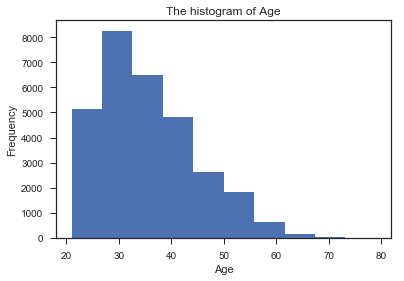

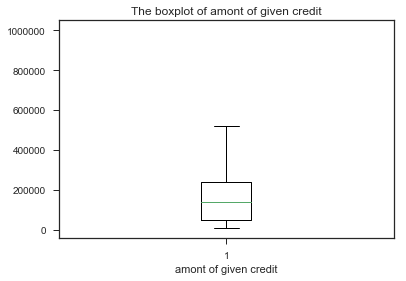

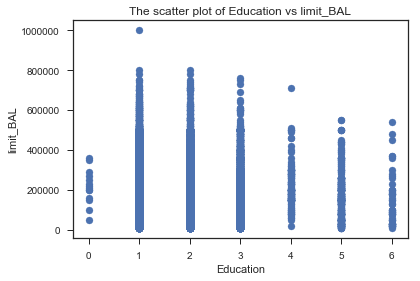

In [21]:
# two visualizations
FIGS_DIR = 'figs'
def savefig(fname, verbose=True):
    path = os.path.join('..', FIGS_DIR, fname)
    plt.savefig(path)
    if verbose:
        print("Figure saved as '{}'".format(path))


fig = plt.figure()
plt.hist(X[:,5])
#plt.yscale('log', nonposy='clip')
plt.title("The histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
savefig('The histogram of age.png' )

fig = plt.figure()
plt.boxplot(X[:,1])
plt.title("The boxplot of amont of given credit")
plt.xlabel("amont of given credit")
savefig('boxplot_of_limit_BAL.png' )


fig = plt.figure()
plt.scatter(X[:,3],X[:,1])
plt.title("The scatter plot of Education vs limit_BAL")
plt.xlabel("Education")
plt.ylabel("limit_BAL")
savefig('The scatter plot of Education vs limit_BAL.png' )

From the histogram, we can get that most clients are 20~40 years old.<br>
From the box plot, for most people, the amount of given credit is in $[40000 , 220000 ]$.<br>
From the scatterplot, clients without education will never get the given credit larger than 400,000.


## 3. Randomly split the data

In [22]:
######### 3.Randomly split the data
'''
index = np.asarray(range(n))
np.random.shuffle(index)
Xrand = X[index,:]
yrand = Y[index]
Yrand = np.array(list(yrand[:]), dtype=np.float)
# Split training data into raining, test and validation sets
Xtrain = Xrand[0:n//3]
ytrain = Yrand[0:n//3]

Xtest = Xrand[n//3:2*(n//3)]
ytest = Yrand[n//3:2*(n//3)]

Xvalid = Xrand[2*(n//3): n]
yvalid = Yrand[2*(n//3): n]
'''
# or use the sklearn model_selection package

from sklearn.model_selection import train_test_split
print(X.shape, Y.shape)
X_train_vali, Xtest, y_train_vali, ytest = \
train_test_split(X, Y, test_size = 1/3, random_state = 42)

Xtrain, Xvalid, ytrain, yvalid = \
train_test_split(X_train_vali, y_train_vali, test_size=0.5, random_state=42)
print(Xtrain.shape, ytrain.shape)
print(Xvalid.shape, yvalid.shape)
print(Xtest.shape, ytest.shape)


(30000, 24) (30000,)
(10000, 24) (10000,)
(10000, 24) (10000,)
(10000, 24) (10000,)


## 4. DummyClassifier as a baseline model

In [27]:
from sklearn.dummy import DummyClassifier
base = DummyClassifier(strategy='most_frequent')
base.fit(Xtrain, ytrain)
y_hat = base.predict(Xvalid)
error = np.mean(y_hat != yvalid)

print("DummyClassifier validation error: %.3f" % error)

DummyClassifier validation error: 0.221


## 5.  Logistic regression

Figure saved as '..\figs\Etrain_Evalid.png'


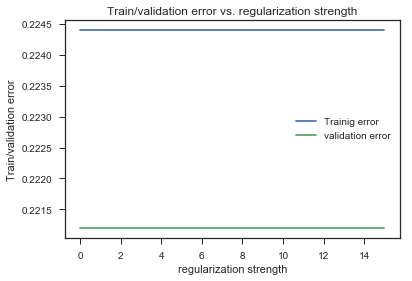

In [29]:
## 5. Logistic regression

from sklearn.linear_model import LogisticRegression

C = [1e-4, 1e-3,1e-2,0.1,0.2,0.3,0.4,0.5,0.8,0.9,1,2,3,4,5,6,7,8,9,10,15]
Etrain = np.zeros(len(C))
Evalid = np.zeros(len(C))

for i in range(len(C)):
    c = 1/C[i]
    model = LogisticRegression(fit_intercept=True, C = c)
    model.fit(Xtrain,ytrain)
    Etrain[i] = np.mean( ytrain != model.predict(Xtrain) )
    Evalid[i] = np.mean( yvalid != model.predict(Xvalid) ) 

FIGS_DIR = 'figs'
def savefig(fname, verbose=True):
    path = os.path.join('..', FIGS_DIR, fname)
    plt.savefig(path)
    if verbose:
        print("Figure saved as '{}'".format(path))

fig = plt.figure()
etrain, = plt.plot(C, Etrain, label="Line 1")
evalid, = plt.plot(C, Evalid, label="Line 2")
plt.legend([etrain, evalid], ['Trainig error', 'validation error'])
plt.title("Train/validation error vs. regularization strength")
plt.xlabel("regularization strength")
plt.ylabel("Train/validation error")

savefig('Etrain_Evalid.png' )

It is strange that training error and validation error keep the same when regularization strength $\lambda$ changes, alough $\lambda$ changes from 0.0001, to 15.<br>
<br>
Training error keeps at 0.2244. Validation error keeps at 0.2212, which is only a slightly smaller than the baseline method.

## 6. Explore the features

C:\Users\Xueting\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0,0.5,'Train/validation error')

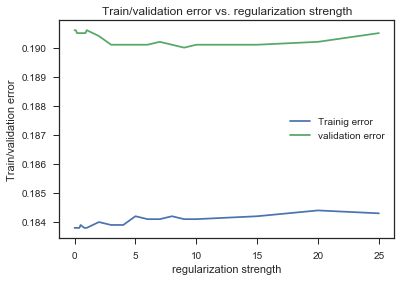

In [31]:
## 6. Explore the features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(Xtrain)  
rXtrain = scaler.transform(Xtrain)  
# apply same transformation to test data
rXtest = scaler.transform(Xtest) 
rXvalid = scaler.transform(Xvalid) 

from sklearn.linear_model import LogisticRegression

C = [1e-4, 1e-3,1e-2,0.1,0.2,0.3,0.4,0.5,0.8,0.9,1,2,3,4,5,6,7,8,9,10,15,20,25]
rEtrain = np.zeros(len(C))
rEvalid = np.zeros(len(C))

for i in range(len(C)):
    c = 1/C[i]
    model = LogisticRegression(fit_intercept=True, C = c)
    model.fit(rXtrain,ytrain)
    rEtrain[i] = np.mean( ytrain != model.predict(rXtrain) )
    rEvalid[i] = np.mean( yvalid != model.predict(rXvalid) ) 

FIGS_DIR = 'figs'
def savefig(fname, verbose=True):
    path = os.path.join('..', FIGS_DIR, fname)
    plt.savefig(path)
    if verbose:
        print("Figure saved as '{}'".format(path))


fig = plt.figure()
retrain, = plt.plot(C, rEtrain, label="Line 1")
revalid, = plt.plot(C, rEvalid, label="Line 2")
plt.legend([retrain, revalid], ['Trainig error', 'validation error'])
plt.title("Train/validation error vs. regularization strength")
plt.xlabel("regularization strength")
plt.ylabel("Train/validation error")
savefig('Etrain_Evalid_feature_scaling.png' )


Feature Scaling:<br>
I center the data around 0 with Scikit-Learn’s preprocessing module.<br>

After scaling, the error gets sightly improved. Training error decreases to 0.1838. Validation error reduces into 0.1901.

## 7. Try 3 other models

In [34]:
## 7. Try 3 other models

# sklearn imports
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from skimage.io import imread, imshow, imsave

## Random Forest

model = RandomForestClassifier()
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xvalid)
v_error = np.mean(y_pred != yvalid)
print("Random Forest (sklearn) validation error: %.3f" % v_error)

model = RandomForestClassifier()
model.fit(rXtrain, ytrain)
y_pred = model.predict(rXvalid)
v_error = np.mean(y_pred != yvalid)
print("After feature scaling, Random Forest (sklearn) validation error: %.3f" % v_error)

## Naive Bayes

model = BernoulliNB()
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xvalid)
v_error = np.mean(y_pred != yvalid)
print("Naive Bayes (sklearn) validation error: %.3f" % v_error)

model = BernoulliNB()
model.fit(rXtrain, ytrain)
y_pred = model.predict(rXvalid)
v_error = np.mean(y_pred != yvalid)
print("After feature scaling, Naive Bayes (sklearn) validation error: %.3f" % v_error)

## Neural Network

#nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
nn = MLPClassifier(random_state=4)
nn.fit( Xtrain , ytrain)
y_predNN = nn.predict(Xvalid)
v_error = np.mean(y_predNN != yvalid)
print("Neural Network(sklearn) validation error: %.3f" % v_error)

nn.fit(rXtrain, ytrain)
y_predNN2 = nn.predict(rXvalid)
v_error = np.mean(y_predNN2 != yvalid)
print("After feature scaling, Neural Network(sklearn) validation error: %.3f" % v_error)


## SVM

from sklearn import svm
clf = svm.SVC()
clf.fit(Xtrain, ytrain)
y_predSVM = clf.predict(Xvalid)
v_error = np.mean(y_predSVM != yvalid)
print("Suppot Vector Machine(sklearn) validation error: %.3f" % v_error)

clf = svm.SVC()
clf.fit(rXtrain, ytrain)
y_predSVM = clf.predict(rXvalid)
v_error = np.mean(y_predSVM != yvalid)
print("After feature scaling, Suppot Vector Machine(sklearn) validation error: %.3f" % v_error)


Random Forest (sklearn) validation error: 0.197
After feature scaling, Random Forest (sklearn) validation error: 0.192

 Naive Bayes (sklearn) validation error: 0.222
After feature scaling, Naive Bayes (sklearn) validation error: 0.339

 Neural Network(sklearn) validation error: 0.313
After feature scaling, Neural Network(sklearn) validation error: 0.184

 Suppot Vector Machine(sklearn) validation error: 0.221
After feature scaling, Suppot Vector Machine(sklearn) validation error: 0.183


From the results, the nerural network and SVM work better than the other methods. But the reseluts shows that actually, they all work not very well with validation error at around 0.2.<br>

I think the reasons may lay in the exploring feature process and the inappropriate hyperparameters. <br>

However, what I learned is that for neural network, feature scaling is essential which will improve performance, like decrease the validation error.

## 8. Optimize hyperparameters

In [ ]:
## 8. optimize hyperparameters

from sklearn.model_selection import GridSearchCV

# 1. choose hyper-para for NN

parameters = {'activation':('relu','logistic'), 'solver':('lbfgs', 'sgd','adam'),\
              'momentum':( 0.5, 0.6, 0.7, 0.8, 0.9)}

nn = MLPClassifier()
clf = GridSearchCV(nn, parameters)
clf.fit(rXtrain, ytrain)
print(clf.best_estimator_)
print("score:", clf.best_score_)

y_predNN2 = clf.predict(rXvalid)
Evalid_nn_hp = np.mean(y_predNN2 != yvalid)
print("After hyperparameter selection, Neural Network(sklearn) validation error: %.3f" % Evalid_nn_hp)

# 2. choose hyper-para for logistic regression


parametersLR = {"C":[1e-4, 1e-3,1e-2,0.1,0.2,0.3,0.4,0.5,0.8,0.9,1,2,3,4,5,6,7,8,9,10,15],\
              "solver" : ("lbfgs", "liblinear", "sag", "saga")}

model = LogisticRegression()
lr = GridSearchCV(model, parametersLR)
lr.fit(rXtrain,ytrain)
print(lr.best_estimator_)
Etrain_hp = np.mean( ytrain != lr.predict(rXtrain) )
Evalid_hp = np.mean( yvalid != lr.predict(rXvalid) ) 
print("After hyperparameter selection, logistic regression validation error: %.3f" % v_error)



<p>
<b>The best model of MLP is :</b>
</p>
<p>
MLPClassifier(<u>activation='relu'</u>, alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=4, shuffle=True,
       <u>solver='sgd'</u>, tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
    
</p>
<p>
<b>The best model of Logistic Regression is :</b>
</p>
<p>
LogisticRegression(<u>C=3</u>, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, <u>solver='saga'</u>, tol=0.0001,
          verbose=0, warm_start=False)
</p>

## 9. Explore feature selection 

I use L0-Regularization to do the feature selection.

In [ ]:
## 9. Explore feature selection    
      
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=10, penalty="l1", dual=False).fit(X_train_vali, y_train_vali)
fs_model = SelectFromModel(lsvc, prefit=True)
X_new = fs_model.transform(X_train_vali)
fs = fs_model.get_support()
print("The selected features: ",fs)
print("After feature selection:",X_new.shape)


Xtrain_fs, Xvalid_fs, ytrain_fs, yvalid_fs = \
train_test_split(X_new, y_train_vali, test_size=0.5, random_state=42)
print(Xtrain_fs.shape, ytrain_fs.shape)
print(Xvalid_fs.shape, yvalid_fs.shape)
print(Xtest.shape, ytest.shape)

### feature scaling
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(Xtrain_fs)  
rXtrain_fs = scaler.transform(Xtrain_fs)  
# apply same transformation to test data
rXvalid_fs = scaler.transform(Xvalid_fs) 


### Logistic regression
parametersLR = {"C":[1e-3,1e-2,0.1,0.2,0.3,0.4,0.5,0.8,0.9,1,2,3,4,5,6,7,8,9,10,15],\
              "solver" : ("lbfgs", "liblinear", "sag", "saga")}

model = LogisticRegression()
lr = GridSearchCV(model, parametersLR)
lr.fit(rXtrain_fs,ytrain_fs)
print(lr.best_estimator_)
Etrain_hs = np.mean( ytrain_fs != lr.predict(rXtrain_fs) )
Evalid_hs = np.mean( yvalid_fs != lr.predict(rXvalid_fs) ) 
print("After feature selection, logistic regression validation error: %.3f" % Evalid_hs)


### NN

parameters = {'activation':('relu','logistic'), 'solver':('lbfgs', 'sgd','adam')}

nn = MLPClassifier()
clf = GridSearchCV(nn, parameters)
clf.fit(rXtrain_fs, ytrain_fs)
print(clf.best_estimator_)
print("score:", clf.best_score_)

y_predNN2 = clf.predict(rXvalid_fs)
Evalid_nn_fs = np.mean(y_predNN2 != yvalid_fs)
print("After feature selection, Neural Network(sklearn) validation error: %.3f" % Evalid_nn_fs)



With feature selection, the validation error is slightly improved.<br>

Still, the performance of nerural network is best.<br>

The selected 10 features are: sex, education, marriage, age, pay_0~pay_6.

## 10. The best model

In [ ]:
## 10. Overall complementation

# the overall best model is NN with feature selection, feature scaling and hyperparameter selection.

# combine the test set with validdation set


scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_new)  

rXtrain_vali_fs = scaler.transform(X_new) 

Xtest_fs = fs_model.transform(Xtest)
rXtest_fs =  scaler.transform(Xtest_fs) 

parameters = {'activation':('relu','logistic'), 'solver':('lbfgs', 'sgd','adam')}

nn = MLPClassifier()
clf = GridSearchCV(nn, parameters)
clf.fit(rXtrain_vali_fs, y_train_vali)
print(clf.best_estimator_)
print("score:", clf.best_score_)

y_pred = clf.predict(rXtest_fs)
Etest_nn = np.mean(y_pred != ytest)
print("After feature selection, Neural Network(sklearn) test error: %.3f" % Etest_nn)

The overall best model is NN with feature selection, feature scaling and hyperparameter selection.<br>

The corresponding test error is 0.181, which is very similar to the validation error. Hence, I do not suffer from the optimization bias in the above implementation.
</p>

## Exercise 3: Very short answer questions
rubric={reasoning:7}

1. Why is it difficult for a standard collaborative filtering model to make good predictions for new items?
2. Consider a fully connected neural network with layer sizes (10,20,20,5); that is, the input dimensionality is 10, there are two hidden layers each of size 20, and the output dimensionality is 5. How many parameters does the network have, including biases?
3. Why do we need nonlinear activation functions in neural networks?
4. Assuming we could globally minimize the neural network objectve, how does the depth of a neural network affect the fundamental trade-off?
5. List 3 forms of regularization we use to prevent overfitting in neural networks.
6. Assuming we could globally minimize the neural network objectve, how would the size of the filters in a convolutational neural network affect the fundamental trade-off?
7. Why do people say convolutional neural networks just a special case of a fully-connected (regular) neural networks? What does this imply about the number of learned parameters?


<h3>_Answer:_</h3>

1. In Netflix prize, collaborative filtering only looks at ratings to make predictions, not features of movies/users. However, new items may have few or no ratings available. Hence, it is hard to predict on new items.

2. In the learning process, we want to find the weights and biases. So the parameters include weights and biases. <br>
From the first layer to second layer, we have $10\times20$ weights and 20 biases.<br>
From the second layer to third layer, we have $20\times20$ weights and 20 biases.<br>
From the third layer to last layer, we have $5\times20$ weights and 5 biases.<br>
Overall, we have 700 weights and 45 biases.

3. Without introducing non-linear activation function, all we have is the linear latent-factor model with linear regression. This is just a linear model, and we cannot deal with non-linear situation with this model.<br>
Therefore, we need non-linear function to increase flexibility.

4. The depth of a neural network is subject to the fundamental trade-off.<br>
As the depth increases, the training error will go down, while the approximation error will go up.

5. The standard regularization.<br>
Early stopping.<br>
Dropout.<br>

6. As the width incerases, the training error will go down, while the approximation error will go up.

7. Because in convolutional neural network, it firstly has the usual neural network layer with unrestricted W, and then restricts W to results of several convolutions.<br>
CNN drastically reduces the number of parameters.
